# Проект e-learning: вариант 2
## Задание   

Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (10 баллов)

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (7 баллов) 

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  (15 баллов) 

6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Описание подхода можно найти тут. (23 балла)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникального идентификатора курса.

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [1]:
import pandas as pd 
import requests 
from urllib.parse import urlencode 
import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline

## Файлы:  
### assessments.csv   
— этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).  

**code_module** — идентификационный код предмета.  
**code_presentation** — семестр (Идентификационный код).  
**id_assessment** — тест (Идентификационный номер ассессмента).  
**assessment_type** — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).  
**date** — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).  
**weight** — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

### courses.csv   
— файл содержит список предметов по семестрам.

**code_module** — предмет (идентификационный код).  
**code_presentation** — семестр (идентификационный код).  
**module_presentation_length** — продолжительность семестра в днях.

### studentAssessment.csv   
— этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

**id_assessment** — тест (идентификационный номер).  
**id_student** — идентификационный номер студента.  
**date_submitted** — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.  
**is_banked** — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).  
**score** — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

### studentRegistration.csv   
— этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.  


**code_module** — предмет (идентификационный код).  
**code_presentation** — семестр (идентификационный код)  
**id_student** — идентификационный номер студента.  
**date_registration** — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).  
**date_unregistration** — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [2]:
# Считать датафрейм
def read_file_yandex_dick(public_key):
    # Функция возвращает считанный датафрейм
    # public_key - ссылка на файл 
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    # загружаем файл в df 
    # download_response = requests.get(download_url) 
    return pd.read_csv(download_url) 

In [3]:
# проверка размерности 
# a, b - датафреймы, размерность которых нужно сравнить 
# dimension - 0 или 1
def checking_equality_shape(a, b, dimension):
    if a.shape[dimension] == b.shape[dimension]:
        print('ok')
    else:
        print('not equal')

In [4]:
# считать файлы
df_assessments = read_file_yandex_dick('https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ')
df_courses = read_file_yandex_dick('https://disk.yandex.ru/d/jmJxR8yhwCXlaw')
df_student_assessment = read_file_yandex_dick('https://disk.yandex.ru/d/DYd4M5b_8RETsA')
df_student_registration = read_file_yandex_dick('https://disk.yandex.ru/d/lqHnH8NOZ458iw')

# Предварительное изучение данных

Одно из самых необходимых и критически важных знаний о данных для выполнения этого задания - сформулировать, что должно считаться курсом. Рассуждая о курсе можно понимать его по разному, например курс “теория вероятности и статистика” в вузе может состоять из двух семестровых частей. Или курс содержит несколько предметов, которые студент проходит одновременно, как в школе или в вузе.  
Для проверки гипотез необходимо учитывать следующие факторы:  
   1. Распределение модулей по семестрам и продолжительности: показывает, что модули в курсе не идут одновременно. Модули, которые бы составляли единый курс должны были бы идти одновременно с одинаковой продолжительностью. По данным из таблицы courses.csv не удалось выделить курсы состоящие не из одного модуля, которые бы студенты проходили одновременно.

In [5]:
# Распределение модулей по полугодиям 
df_courses.groupby(['code_presentation'])['code_module']\
    .agg(list)

code_presentation
2013B                        [BBB, DDD, FFF]
2013J         [AAA, BBB, DDD, EEE, FFF, GGG]
2014B         [BBB, CCC, DDD, EEE, FFF, GGG]
2014J    [AAA, BBB, CCC, DDD, EEE, FFF, GGG]
Name: code_module, dtype: object

In [6]:
# Распределение модулей по семестрам и продолжительности. 
df_courses.groupby(['code_presentation', 'module_presentation_length'])['code_module']\
    .agg(list)

code_presentation  module_presentation_length
2013B              240                                     [BBB, DDD, FFF]
2013J              261                                          [DDD, GGG]
                   268                                [AAA, BBB, EEE, FFF]
2014B              234                                               [BBB]
                   241                           [CCC, DDD, EEE, FFF, GGG]
2014J              262                                          [BBB, DDD]
                   269                           [AAA, CCC, EEE, FFF, GGG]
Name: code_module, dtype: object

2. **Тесты и экзамены (assessment_type)**: Успешное завершение курса связано с сдачей тестов и экзаменов. Для данной проверки было проведено следующее исследование данных:
    - Выявила на каких модулях студенты пишут экзамены (только на ССС и DDD)
    - Сделала merge трех таблиц (student_assessment, assessments, student_registration) и посмотрела, какой суммарный вес у студентов  с **date_unregistration ==** NaN (то есть те кто не вернул курс) и какой суммарный вес сделанных ими задач (от 0 до 200, причем >100 баллов только у тех, кто сдавал ССС и DDD модули)
    - В модуле GGG вес оценок == 0

In [7]:
# Студенты сдавали экзамены только на модулях 'CCC', 'DDD'

df_merge_st_assessment = df_student_assessment.merge(df_assessments, on='id_assessment')
df_assessment_students_data = df_merge_st_assessment\
    .merge(df_student_registration, 
           how='left', 
           on=['id_student', 'code_module', 'code_presentation'])
df_assessment_students_data[df_assessment_students_data.assessment_type == 'Exam'].code_module.unique()

array(['CCC', 'DDD'], dtype=object)

In [8]:
df_merge_st_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [9]:
df_assessment_students_data.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,-159.0,NaN
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,-53.0,NaN
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,-52.0,NaN
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,-176.0,NaN
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,-110.0,NaN


In [10]:
df_merge_st_assessment.groupby(['code_module', 'code_presentation', 'id_student'], as_index=False)\
    .agg({'weight': 'sum'}).sort_values('weight')

,code_module,code_presentation,id_student,weight
25842,GGG,2014J,2684003,0.0
24305,GGG,2013J,598762,0.0
24304,GGG,2013J,598731,0.0
24303,GGG,2013J,598717,0.0
24302,GGG,2013J,598667,0.0
...,...,...,...,...
11305,DDD,2013J,89188,200.0
11310,DDD,2013J,102850,200.0
11311,DDD,2013J,103800,200.0
11286,DDD,2013J,59370,200.0


In [11]:
# Колдичество баллов за модуль  
df_assessment_students_data.query("date_unregistration == 'NaN'")\
    .groupby(['code_presentation', 'code_module', 'id_student'], as_index=False)\
    .agg({'weight': 'sum'})\
    .sort_values('weight', ascending=False)\
    .query("code_module != 'DDD' and code_module != 'CCC'")\
    .head(10)

,code_presentation,code_module,id_student,weight
9710,2014B,BBB,613093,100.0
19061,2014J,EEE,698300,100.0
15144,2014J,BBB,655084,100.0
9703,2014B,BBB,612721,100.0
9704,2014B,BBB,612756,100.0
9705,2014B,BBB,612841,100.0
19377,2014J,FFF,498442,100.0
14667,2014J,BBB,582253,100.0
15098,2014J,BBB,652156,100.0
15096,2014J,BBB,652090,100.0


In [12]:
# На модуле GGG нет весов для оценок
df_assessments.query("code_module == 'GGG' and assessment_type !='Exam'")\
    .groupby(["code_presentation", "assessment_type"])\
    .agg({"weight": "sum"})

weight
code_presentation assessment_type        
2013J             CMA                 0.0
                  TMA                 0.0
2014B             CMA                 0.0
                  TMA                 0.0
2014J             CMA                 0.0
                  TMA                 0.0

3. **История прохождения модулей студентами** может показать, какие модули студенты проходили вместе/один за другим. Мне кажется, что если курс состоит из нескольких модулей, то не может быть такой ситуации, что один студент проходит только финальный модуль “CCC” в 2014 году, а другой проходит “CCC” и “FFF” одновременно.
    - Примеры истории прохождения курса студентами
        
        *Студенты проходят вообще разные наборы модулей.* 
        
        *Примеры:*
        
        *студент 596846 он прошел два курса только по модулям ССС и DDD.*
        
        *228695 - проходил модули D и F одновременно, но не прошел до конца D*
        
        *607555 - сдал два экзамена* 
        
        *537811 - прошел три модуля (CFD), но завершил только 2 курса, написав 2 экзамена* 
        
        *607600 - вообще отправлял решение задания через 21 день после начала курса, а ушел с курса на 12-ый.*
        
        *391249 - проходил модуль AAA и все*
        
        *134847 - проходил модуль FFF 2 раза, первый из них неудачно*
        
        *142324 - два раза проходил курс ВВВ (в разных семестрах)*

In [13]:
# Детальное изучение истории прохождения модулей студентами 
id_stud = 523857 
df_assessment_students_data[df_assessment_students_data.id_student == id_stud]\
    .sort_values(['code_presentation', 'date_submitted'])

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration
14926,14996,523857,11,0,72.0,BBB,2013J,TMA,19.0,5.0,-100.0,NaN
16701,14997,523857,45,0,73.0,BBB,2013J,TMA,47.0,18.0,-100.0,NaN
22827,15003,523857,56,0,80.0,BBB,2013J,CMA,54.0,1.0,-100.0,NaN
18826,14998,523857,94,0,68.0,BBB,2013J,TMA,96.0,18.0,-100.0,NaN
24390,15004,523857,102,0,100.0,BBB,2013J,CMA,96.0,1.0,-100.0,NaN
19309,14999,523857,129,0,63.0,BBB,2013J,TMA,131.0,18.0,-100.0,NaN
26350,15005,523857,133,0,60.0,BBB,2013J,CMA,131.0,1.0,-100.0,NaN
20616,15000,523857,164,0,90.0,BBB,2013J,TMA,166.0,18.0,-100.0,NaN
26817,15006,523857,168,0,100.0,BBB,2013J,CMA,166.0,1.0,-100.0,NaN
22272,15001,523857,206,0,75.0,BBB,2013J,TMA,208.0,18.0,-100.0,NaN


In [14]:
# На какие курсы был записан студент 
df_student_registration.query(f"id_student == {id_stud}")

,code_module,code_presentation,id_student,date_registration,date_unregistration
3188,BBB,2013J,523857,-100.0,NaN
16661,DDD,2014B,523857,-110.0,NaN


4. **Количество пройденных модулей:**
    - при исследовании количества модулей, которые студент прошел/проходит, было выявлено, что небольшое число студентов закончило более 1 модуля (21660 - проходили 1 модуль, 1700 - проходили 2 модуля, 9 - 3 модуля)
    - C модулем DDD студенты проходили разные модули.

In [15]:
# Студенты проходили 1 2 или 3 модулей
df_assessment_students_data\
    .groupby(['id_student'])['code_module']\
    .nunique()\
    .to_frame()\
    .reset_index()\
    .rename(columns={'code_module': 'completed_module'})\
    .groupby(['completed_module'])\
    .agg({'id_student': 'count'})

,id_student
completed_module,
1,21660
2,1700
3,9


In [16]:
# Выведем студентов, которые сдавали хотя бы 1 экзамен
df_students_pass_exam = df_merge_st_assessment\
    .query("assessment_type == 'Exam'")\
    .groupby('id_student', as_index=False)\
    .agg({'code_presentation': 'count'})\
    .rename(columns={'code_presentation': 'count_exam'})

In [17]:
df_students_pass_exam_module = df_merge_st_assessment\
    .merge(df_students_pass_exam, on='id_student')

In [18]:
# Модули, которые проходит студент, вместе с модулями, на которых сдают экзамены 
df_students_pass_exam_module.groupby(['id_student', 'code_module'], as_index=False)\
    .agg({'code_presentation': 'count'})\
    .groupby('id_student')['code_module']\
    .agg(list).to_frame().reset_index()\
    .sort_values('code_module')

,id_student,code_module
1341,523857,"[BBB, DDD]"
2756,609194,"[BBB, DDD]"
2209,583775,"[BBB, DDD]"
781,422542,[CCC]
2948,622302,[CCC]
...,...,...
1701,554881,"[DDD, FFF]"
4468,2499307,"[DDD, FFF]"
1852,562064,"[DDD, FFF]"
2708,607483,"[DDD, GGG]"


5. **Количество модулей и экзаменов, которые проходил и сдавал студент**  
    - В основном студенты, которые сдавали хоты бы 1 экзамен, проходили 1 модуль

In [19]:
# Количество модулей, которые проходил студент 
df_modules_exam = df_students_pass_exam_module.groupby(['id_student'], as_index=False)['code_module']\
    .nunique().sort_values(by='code_module', ascending=False)\
    .rename(columns={'code_module': 'count_module'})\
    .merge(df_students_pass_exam, on='id_student')

In [20]:
df_modules_exam.groupby(['count_module', 'count_exam'])\
    .agg({'id_student': 'count'})

id_student
count_module count_exam            
1            1                 3574
             2                    4
2            1                  731
             2                  321
3            1                    2
             2                    1

Думаю, стоит пояснить почему получилось так, что у нас есть 4 студента, которые сдавали экзамены 2 раза, но проходили 1 модуль. Данные студенты проходили 2 раза 1 и тотже модуль. Причем они не пересдавали курс, а прошли его заново. 

In [21]:
id_stud = df_modules_exam.query("count_exam == 2 and count_module == 1").id_student.to_list()

In [22]:
df_assessment_students_data[df_assessment_students_data.id_student.isin(id_stud)]\
    .sort_values(['code_presentation', 'date_submitted']). query("is_banked == 1")

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration


5. **Распределение студентов** (которые не вернули курс): 
    - Было построено распределение числа студентов по семестрам и модулям. При детальном изучении распределений было выявлено, что модули не сочетаются так, чтобы получить полноценный курс с экзаменом в конце (за бортом оставался бы модуль, количество учеников на котором меньше, чем сдавало экзамен)

In [23]:
# Постоим распределение студетов по модулям и семестрам
df_cours = df_assessment_students_data.query("date_unregistration == 'NaN'")\
    .groupby(['code_presentation', 'code_module'], as_index=False)['id_student']\
    .nunique()\
    .rename(columns={'id_student': 'count_student'})

In [24]:
df_cours.head()

,code_presentation,code_module,count_student
0,2013B,BBB,1155
1,2013B,DDD,814
2,2013B,FFF,1150
3,2013J,AAA,319
4,2013J,BBB,1500


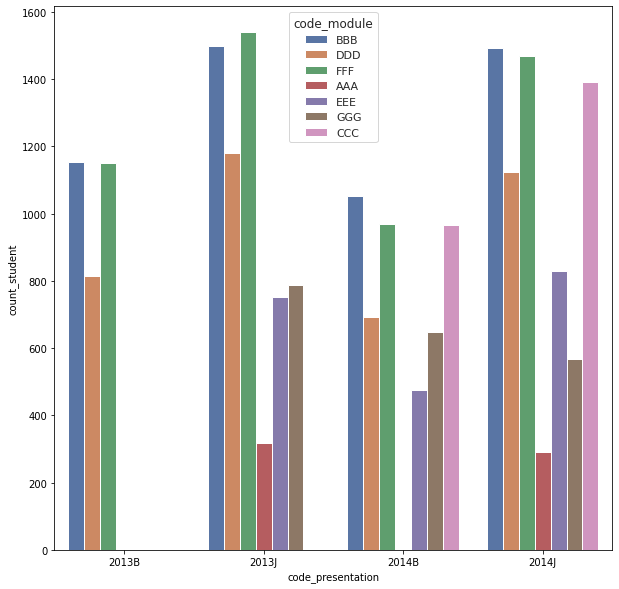

In [25]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(style="whitegrid")
sns.barplot(data=df_cours, x='code_presentation', y='count_student', hue='code_module')

# Вывод:
При анализе данных было выявлено, что модуль = курсу, а завершенность курса будет определяться для CCC и DDD: студент отправил экзамен на проверку и получил за него не менее 40 баллов. 

На остальных модулях нет экзамена, следовательно для них можно выявить другое правило завершения курса: студент отправил все задания (общий вес отправленных работ = 100) и за все задания студент получил оценку больше 40. Модуль GGG буду считать бесплатным курсом, по итогам которого не дают сертификат о прохождении, поэтому баллы за задания считать не нужно (вес каждого задания 0) 

В некоторых заданиях четко прописано, что считать успешной сдачей курса, поэтому я нахожусь в некотором смятении, так как большая часть данных останется без внимания, поэтому я склоняюсь к тому, что буду прорешивать задания двумя способами:

- Принимая во внимае только условия задания
- Принимая во внимание выводы, которые были получены в ходе исследования данных

# Задачи:
## 1.1 Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) 

Из задания понятно, что необходимо посчитать количество студентов, которые сдали экзамен на оценку выше 40 и при чем только 1. 

In [26]:
df_merge_st_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [27]:
# Количество студентов, которые успешно сдали только один курс
# Что делать с ребятами, которые сдали только 1 курс, но 2 раза, думаю нужно их считать как тех, кто сдал 1 курс.
df_merge_st_assessment\
    .query("assessment_type == 'Exam' and score >= 40")\
    .groupby(['id_student'], as_index=False)['code_module']\
    .nunique()\
    .rename(columns={'code_module': 'count_good_exam'})\
    .query("count_good_exam == 1")\
    .shape[0]

3805

In [28]:
# Студенты, которые успешно сдали 2 курса
df_merge_st_assessment\
    .query("assessment_type == 'Exam' and score >= 40")\
    .groupby(['id_student'], as_index=False)['code_module']\
    .nunique()\
    .rename(columns={'code_module': 'count_good_exam'})\
    .query("count_good_exam == 2")\
    .shape[0]

292

In [29]:
# Всего студентов, которые сдали хотя бы 1 курс
df_merge_st_assessment\
    .query("assessment_type == 'Exam' and score >= 40")\
    .groupby(['id_student'], as_index=False)\
    .agg({'date_submitted': 'count'})\
    .rename(columns={'date_submitted': 'count_good_exam'})\
    .shape[0]

4097

### 3805 студентов успешно сдали 1 курс (Успешная сдача — это зачёт по курсу на экзамене)

Получилось, что таких студентов - 3805. Студентов, которые сдали 2 экзамена - 292, а всего студентов, которые сдали хотя бы 1 экзамен 4097 (вроде, даже все сошлось)

### 1.2 Сколько студентов успешно сдали только один курс?
Если придерживаться другого определения курса: завершенность курса будет определяться для CCC и DDD: студент отправил экзамен на проверку и получил за него более 40 баллов; а для остальных курсов: студент отправил все задания (общий вес отправленных работ = 100) и за все задания студент получил оценку больше 40. 

In [30]:
df_assessment_students_data.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,-159.0,NaN
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,-53.0,NaN
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,-52.0,NaN
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,-176.0,NaN
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,-110.0,NaN


успешные сдачи курсов без экзаменов  

Поясню зачем при группировке мне нужно группировать и по семестру(code_presentation). 
В данных есть студенты, которые не вернули курс = модулю, и проходят его заново в другом модуле. Получается, что может быть такая ситуация при которой студент два раза пытался пройти курс, но у него 2 раза не получилось, а баллов он набрал дважды больше 50 => получается, чтосуммарно у него больше 100. Поэтому необходимо группировать и по семестру тоже.  

In [31]:
# Успешные сдачи курсов без экзаменов

df_studen_without_exam = df_assessment_students_data\
    .query("code_module != 'CCC' and code_module != 'DDD' and score >= 40 and date_unregistration == 'NaN'")\
    .groupby(['id_student', 'code_module', 'code_presentation'], as_index=False)\
    .agg({'weight': 'sum'})\
    .query("weight == 100")
df_studen_without_exam.tail()

,id_student,code_module,code_presentation,weight
14921,2697921,FFF,2014J,100.0
14922,2698125,FFF,2013J,100.0
14923,2698257,AAA,2013J,100.0
14925,2698577,BBB,2014J,100.0
14926,2698588,BBB,2014J,100.0


In [32]:
# Успешные сдачи экзаменов
df_studen_with_exam = df_assessment_students_data\
    .query("assessment_type == 'Exam' and score >= 40")\
    .groupby(['id_student', 'code_module', 'code_presentation'], as_index=False)\
    .agg({'weight': 'sum'})
df_studen_with_exam.head()

,id_student,code_module,code_presentation,weight
0,23698,CCC,2014J,100.0
1,24213,DDD,2014B,100.0
2,27116,CCC,2014J,100.0
3,28046,DDD,2013J,100.0
4,28787,CCC,2014J,100.0


In [33]:
# Число студентов, которые сдали только 1 курс
df_studen_without_exam.append(df_studen_with_exam)\
    .groupby(['id_student'], as_index=False)['code_module']\
    .nunique()\
    .query("code_module == 1")\
    .shape[0]

11119

1.2 Если принять во внимание вывод, который был сделан из предварительного изучения данных, то количество студентов, которые прошли один курс вырастет до 11119 студентов.

## 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.
*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен  
Можно поделить данный пункт на два подраздела:
- Найти самый сложный экзамен внутри курса
- Найти самый сложный курс для прохождения

### найдем экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.

In [34]:
df_merge_st_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [35]:
df_exam = df_merge_st_assessment\
    .query("assessment_type == 'Exam'")

In [36]:
df_exam['pass_exam'] = df_exam['score'].apply(lambda x: 1 if x >= 40 else 0)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_pass_exam_percent_of_exam = df_exam\
    .groupby(['code_module'], as_index=False)\
    .agg({'pass_exam': 'mean'})\
    .sort_values('pass_exam')
df_pass_exam_percent_of_exam['percent_pass_exam'] = round(df_pass_exam_percent_of_exam.pass_exam * 100, 2)

In [38]:
df_pass_exam_percent_of_exam

,code_module,pass_exam,percent_pass_exam
0,CCC,0.878851,87.89
1,DDD,0.889947,88.99


[Text(0, 0.5, 'Процент студентов, которые сдали экзамен'),
 Text(0.5, 0, 'Модуль')]

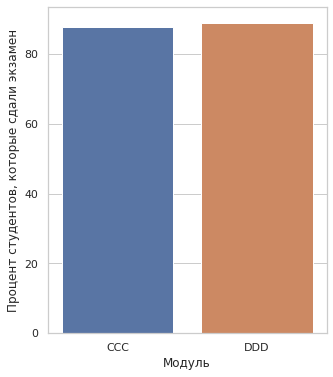

In [39]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=df_pass_exam_percent_of_exam, x='code_module', y='percent_pass_exam')
ax.set(ylabel="Процент студентов, которые сдали экзамен",
       xlabel="Модуль")

#### Экзамены на курсах CCC (завершаемость = 87.89%) и DDD (завершаемость = 88.99%) практически одинаковой сложности

### Найдем самый сложный и самый простой курс

#### Будем исследовать студентов, которые проходили модули с экзаменами

In [40]:
df_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,pass_exam
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,1
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,1
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,1
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,1


In [41]:
# Количество студентов, которые сдали экзамены
df_pass_exam = df_exam.query("pass_exam == 1")\
    .groupby(["code_module"], as_index=False)\
    .agg({'weight': 'count'})\
    .rename(columns={'weight': 'pass_students'})

In [42]:
df_merge_st_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


Количество студентов, которые проходили курсы CCC и DDD (отправили хотя бы одно задание на проверку)
Один и тотже студент мог начинать проходить курс в разные полугодия, поэтому необходимо считать каждое полугодие отдельно, а потом все складывать. И необходимо убрать из данных студентов, которые брали академ, в противном случае их данные будут учитываться дважды.

In [43]:
df_took_course = df_merge_st_assessment.query("(code_module == 'CCC' or code_module == 'DDD') and is_banked != 1")\
    .groupby(["code_module", "code_presentation"], as_index=False)["id_student"].nunique()\
    .groupby(["code_module"], as_index=False).agg({'id_student': 'sum'})\
    .rename(columns={'id_student': 'passing_module'})

In [44]:
df_pass_exam = df_pass_exam.merge(df_took_course, on='code_module')

In [45]:
df_pass_exam

,code_module,pass_students,passing_module
0,CCC,1683,3397
1,DDD,2709,4856


In [46]:
df_pass_exam['completed_course'] = round(df_pass_exam.pass_students / df_pass_exam.passing_module * 100, 2)

In [47]:
df_pass_exam

,code_module,pass_students,passing_module,completed_course
0,CCC,1683,3397,49.54
1,DDD,2709,4856,55.79


[Text(0, 0.5, 'Процент студентов, которые прошли модуль'),
 Text(0.5, 0, 'Модуль')]

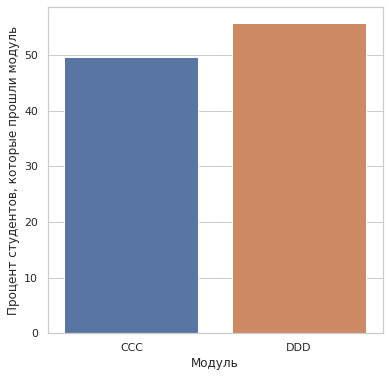

In [48]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=df_pass_exam, x='code_module', y='completed_course')
ax.set(ylabel="Процент студентов, которые прошли модуль",
       xlabel="Модуль")

### Курс CCC (48.43 % студентов сдают экзамен) более сложный, чем DDD (54.30 % студентов сдают экзамен)

#### Выявим то, как студенты проходят курсы, на которых не сдают экзамены 

In [49]:
# успешные сдачи курсов без экзаменов
df_studen_without_exam.head()

,id_student,code_module,code_presentation,weight
0,6516,AAA,2014J,100.0
1,11391,AAA,2013J,100.0
3,23798,BBB,2013J,100.0
7,25107,BBB,2013B,100.0
8,25150,EEE,2014B,100.0


In [50]:
df_pass_module = df_studen_without_exam.groupby(['code_module'], as_index=False)\
    .agg({'id_student': 'count'})\
    .rename(columns={'id_student': 'pass_module'})

In [51]:
df_pass_module

,code_module,pass_module
0,AAA,512
1,BBB,2812
2,EEE,1563
3,FFF,3342


In [52]:
# Общее количество студентов, которые проходили модуль
df_took_module = df_assessment_students_data\
    .query("code_module != 'GGG' and code_module != 'CCC' and code_module != 'DDD' and is_banked != 1")\
    .groupby(['code_module', 'code_presentation'], as_index=False)['id_student']\
    .nunique().groupby(['code_module'], as_index=False).agg({'id_student': 'sum'})\
    .rename(columns={'id_student': 'took_module'})

In [53]:
df_pass_module = df_pass_module.merge(df_took_module, on='code_module')

In [54]:
df_pass_module['completed_course'] = round(df_pass_module.pass_module / df_pass_module.took_module * 100, 2)

In [55]:
df_pass_module

,code_module,pass_module,took_module,completed_course
0,AAA,512,697,73.46
1,BBB,2812,6026,46.66
2,EEE,1563,2283,68.46
3,FFF,3342,6210,53.82


In [56]:
df_pass = df_pass_module.append(df_pass_exam)
df_pass

,code_module,pass_module,took_module,completed_course,pass_students,passing_module
0,AAA,512.0,697.0,73.46,NaN,NaN
1,BBB,2812.0,6026.0,46.66,NaN,NaN
2,EEE,1563.0,2283.0,68.46,NaN,NaN
3,FFF,3342.0,6210.0,53.82,NaN,NaN
0,CCC,NaN,NaN,49.54,1683.0,3397.0
1,DDD,NaN,NaN,55.79,2709.0,4856.0


[Text(0, 0.5, 'Процент студентов, которые прошли модуль'),
 Text(0.5, 0, 'Модуль')]

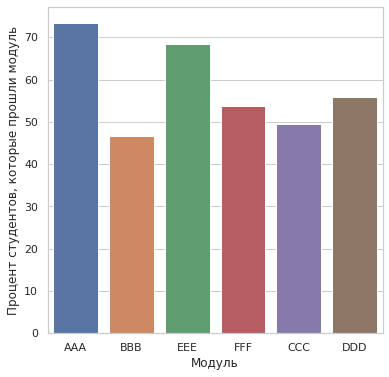

In [57]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=df_pass, x='code_module', y='completed_course')
ax.set(ylabel="Процент студентов, которые прошли модуль",
       xlabel="Модуль")

### Курс AAA оказался самым простым для студентов, а самый сложный курс оказался BBB.

## 3. По каждому предмету определи средний срок сдачи экзаменов

In [58]:
df_exam_time = df_exam.query("pass_exam == 1")\
    .groupby(['code_module', 'code_presentation', 'id_student'], as_index=False)\
    .agg({'date_submitted': 'max'})


In [59]:
df_exam_time.head()

,code_module,code_presentation,id_student,date_submitted
0,CCC,2014B,29764,230
1,CCC,2014B,29820,230
2,CCC,2014B,40604,234
3,CCC,2014B,42638,230
4,CCC,2014B,46605,230


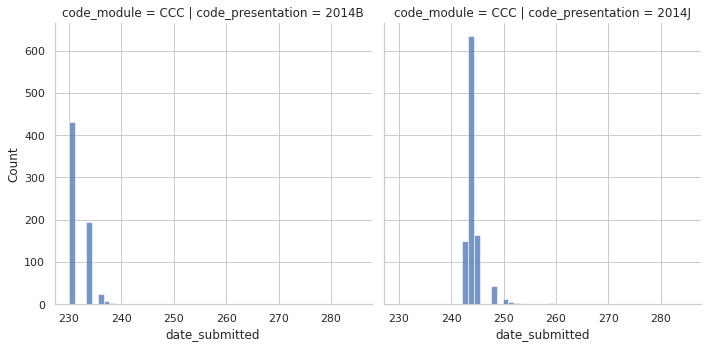

In [60]:
sns.displot(data=df_exam_time.query("code_module == 'CCC'"), col="code_presentation", row="code_module",
            x='date_submitted', bins=50)

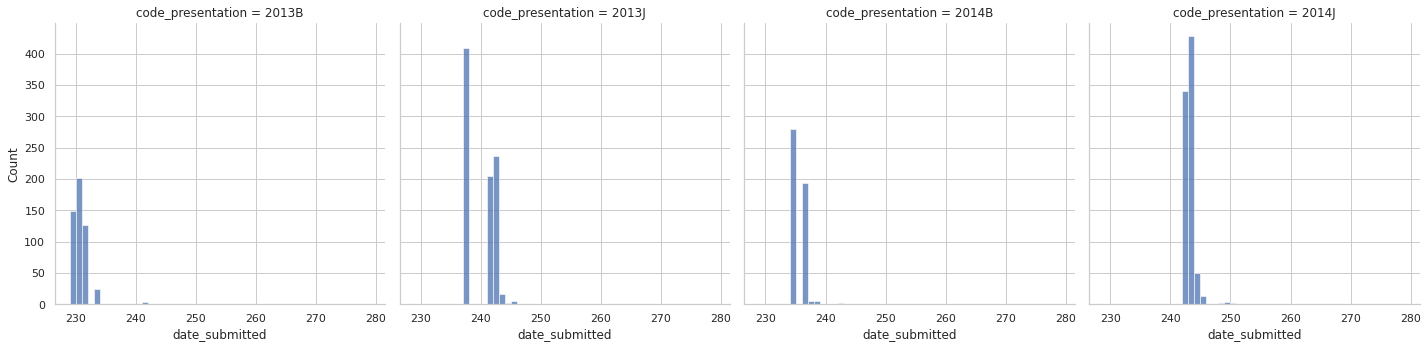

In [61]:
sns.displot(data=df_exam_time.query("code_module == 'DDD'"), col="code_presentation",
            x='date_submitted', bins=50)

Средний срок сдачи экзаменов зависит не только от модуля, который проходил студент, но и от семестра. 

In [62]:
df_exam_time.groupby(['code_module', 'code_presentation'], as_index=False)\
    .agg({'date_submitted': ['median', 'mean', 'max', 'min']})

code_module code_presentation date_submitted                      
                                        median        mean  max  min
0         CCC             2014B            230  231.581325  266  230
1         CCC             2014J            244  244.404318  285  243
2         DDD             2013B            230  230.164683  241  229
3         DDD             2013J            241  239.509112  255  237
4         DDD             2014B            234  234.936082  251  234
5         DDD             2014J            243  242.804038  279  242

In [63]:
df_exam_time.groupby(['code_module'], as_index=False)\
    .agg({'date_submitted': 'median'})

,code_module,date_submitted
0,CCC,244
1,DDD,237


В среднем модуль DDD студенты проходили быстрее, чем CCC

## 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 

In [64]:
df_student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [65]:
# Всего студентов
df_student_registration\
    .groupby(['code_module', 'code_presentation'], as_index=False)['id_student']\
    .nunique().id_student.sum()

32593

In [66]:
# Студенты, которые зарегистрированны на курс 
df_count_registered = df_student_registration.code_module.value_counts()\
    .to_frame().reset_index()\
    .rename(columns={'index': 'code_module', 'code_module': 'registered'})

In [67]:
df_count_registered

,code_module,registered
0,BBB,7909
1,FFF,7762
2,DDD,6272
3,CCC,4434
4,EEE,2934
5,GGG,2534
6,AAA,748


In [68]:
top_3 = df_count_registered.head(3)

In [69]:
# Количество студентов, которые отчислились с курса
df_outflow_students = df_student_registration\
    .query("date_unregistration != 'NaN'")\
    .groupby('code_module', as_index=False)\
    .agg({'id_student': 'count'})\
    .rename(columns={'id_student': 'outflow_students'})\
    .sort_values(by='outflow_students', ascending=False)

In [70]:
df_student_registration\
    .query("date_unregistration != 'NaN'").shape

(10072, 5)

In [71]:
df_count_outflow_registered = df_outflow_students.merge(df_count_registered, on='code_module')

In [72]:
df_count_outflow_registered.head()

,code_module,outflow_students,registered
0,FFF,2380,7762
1,BBB,2377,7909
2,DDD,2235,6272
3,CCC,1947,4434
4,EEE,718,2934


In [73]:
# Процент студентов, которые отчислились
df_count_outflow_registered['outflow'] = df_count_outflow_registered.outflow_students \
    / df_count_outflow_registered.registered * 100


In [74]:
outsiders_top_3 = df_count_outflow_registered.sort_values('outflow', ascending=False).head(3)

### Предметы с самым большим оттоком

In [75]:
outsiders_top_3

,code_module,outflow_students,registered,outflow
3,CCC,1947,4434,43.910690
2,DDD,2235,6272,35.634566
0,FFF,2380,7762,30.662200


[Text(0, 0.5, 'Отток, %'), Text(0.5, 0, 'Модуль')]

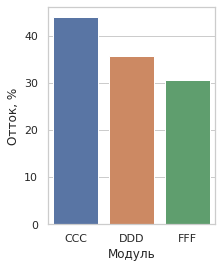

In [76]:
f, ax = plt.subplots(figsize=(3, 4))
sns.barplot(data=outsiders_top_3, x='code_module', y='outflow')
ax.set(ylabel="Отток, %",
       xlabel="Модуль")

### Самые популярные предметы (ТОП-3) по количеству регистраций

In [77]:
top_3

,code_module,registered
0,BBB,7909
1,FFF,7762
2,DDD,6272


[Text(0, 0.5, 'Число студентов, зарегестрированных на курс'),
 Text(0.5, 0, 'Модуль')]

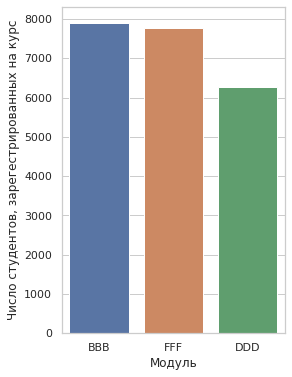

In [78]:
f, ax = plt.subplots(figsize=(4, 6))
sns.barplot(data=top_3, x='code_module', y='registered')
ax.set(ylabel="Число студентов, зарегестрированных на курс",
       xlabel="Модуль")

## 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

### Выявим семестр с самой низкой завершаемостью

In [79]:
df_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,pass_exam
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,1
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,1
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,1
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,1


In [80]:
# Посчитаем количество студентов, которые сдали экзамен (с разбивкой по семестрам и курсам)
df_pass_exam_per_modul = df_exam_per_presentation = df_exam\
    .groupby(['code_presentation', 'code_module'], as_index=False)\
    .agg({'pass_exam': 'sum'})
df_pass_exam_per_modul

,code_presentation,code_module,pass_exam
0,2013B,DDD,504
1,2013J,DDD,878
2,2014B,CCC,664
3,2014B,DDD,485
4,2014J,CCC,1019
5,2014J,DDD,842


In [81]:
# Студенты, которые брали курс (с разбивкой по семестрам и курсам)
df_took_per_modul = df_merge_st_assessment.query("(code_module == 'CCC' or code_module == 'DDD') and is_banked != 1")\
    .groupby(["code_module", "code_presentation"], as_index=False)["id_student"].nunique()\
    .rename(columns={'id_student': 'took_course'})

In [82]:
df_took_per_modul = df_took_per_modul.merge(df_pass_exam_per_modul, on=['code_presentation', 'code_module'])

In [83]:
df_took_per_modul['percent'] = df_took_per_modul['pass_exam'] / df_took_per_modul['took_course']

In [84]:
df_took_per_modul

,code_module,code_presentation,took_course,pass_exam,percent
0,CCC,2014B,1415,664,0.469258
1,CCC,2014J,1982,1019,0.514127
2,DDD,2013B,1058,504,0.476371
3,DDD,2013J,1478,878,0.594046
4,DDD,2014B,929,485,0.522067
5,DDD,2014J,1391,842,0.605320


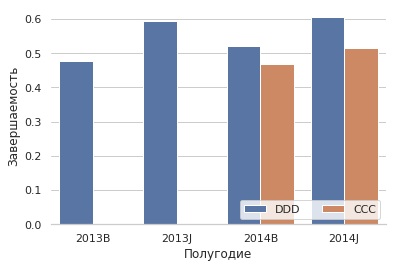

In [85]:
f, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=df_took_per_modul.sort_values('code_presentation'), x='code_presentation', 
            y='percent', hue='code_module')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Завершаемость",
       xlabel="Полугодие")
sns.despine(left=True)

### Вычислим среднее время завершения курса 

In [86]:
# Вычислим среднее время завершения курсов 
df_exam_time_per_presentation = df_exam_time.groupby(['code_module', 'code_presentation'], as_index=False)\
    .agg({'date_submitted': 'mean'})
df_exam_time_per_presentation

,code_module,code_presentation,date_submitted
0,CCC,2014B,231.581325
1,CCC,2014J,244.404318
2,DDD,2013B,230.164683
3,DDD,2013J,239.509112
4,DDD,2014B,234.936082
5,DDD,2014J,242.804038


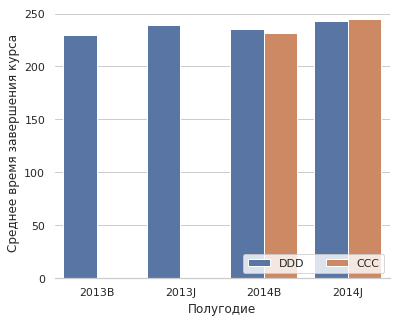

In [87]:
f, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=df_exam_time_per_presentation.sort_values(by='code_presentation'), x='code_presentation', 
            y='date_submitted', hue='code_module')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Среднее время завершения курса",
       xlabel="Полугодие")
sns.despine(left=True)

Семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов - CCC полугодие 2014B.

### Продолжительность и срок сдачи курсов без экзамена

In [88]:
df_without_exam_completion = df_merge_st_assessment.query("code_module != 'CCC' and code_module != 'DDD'")

In [89]:
df_without_exam_completion

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0
...,...,...,...,...,...,...,...,...,...,...
173907,37443,527538,227,0,60.0,GGG,2014J,CMA,229.0,0.0
173908,37443,534672,229,0,100.0,GGG,2014J,CMA,229.0,0.0
173909,37443,546286,215,0,80.0,GGG,2014J,CMA,229.0,0.0
173910,37443,546724,230,0,100.0,GGG,2014J,CMA,229.0,0.0


In [90]:
df_complete_course_date = df_assessment_students_data\
    .query("code_module != 'CCC' and code_module != 'DDD' and score >= 40 and date_unregistration == 'NaN'")\
    .groupby(['id_student', 'code_module', 'code_presentation'], as_index=False)\
    .agg({'weight': 'sum', 'date_submitted': 'max'})\
    .query("weight == 100").sort_values('code_presentation')

In [91]:
df_complete_course_date_plot = df_complete_course_date.groupby(['code_presentation', 'code_module'], as_index=False)\
    .agg({'date_submitted': 'mean'}).sort_values('code_presentation')
df_complete_course_date_plot.head()

,code_presentation,code_module,date_submitted
0,2013B,BBB,189.298354
1,2013B,FFF,205.110964
2,2013J,AAA,214.472325
3,2013J,BBB,209.565753
4,2013J,EEE,159.112457


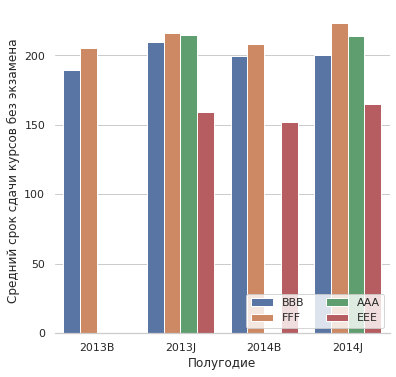

In [92]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=df_complete_course_date_plot.sort_values(by='code_presentation'), x='code_presentation', 
            y='date_submitted', hue='code_module')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Средний срок сдачи курсов без экзамена",
       xlabel="Полугодие")
sns.despine(left=True)

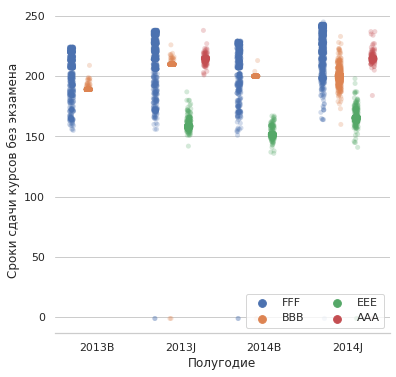

In [93]:
f, ax = plt.subplots(figsize=(6, 6))
sns.stripplot(
    data=df_complete_course_date, x="code_presentation", y="date_submitted", hue="code_module",
    dodge=True, alpha=.25, zorder=1
)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Сроки сдачи курсов без экзамена",
       xlabel="Полугодие")
sns.despine(left=True)

### Завершаемость курсов без экзамена 

In [94]:
# Сдали все тесты по модулю
df_without_exem_complete_course_date = df_complete_course_date\
    .groupby(['code_presentation', 'code_module'], as_index=False)\
    .agg({'weight': 'count'}).rename(columns={'weight': 'complete_course'})

In [95]:
df_took_module.head()

,code_module,took_module
0,AAA,697
1,BBB,6026
2,EEE,2283
3,FFF,6210


In [96]:
df_assessment_students_data.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,-159.0,NaN
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,-53.0,NaN
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,-52.0,NaN
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,-176.0,NaN
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,-110.0,NaN


In [97]:
df_without_exem_took_course_date = df_assessment_students_data\
    .query("code_module != 'CCC' and code_module != 'DDD'")\
    .groupby(['code_module', 'code_presentation'], as_index=False)['id_student']\
    .nunique().rename(columns={'id_student': 'took_course'})

In [98]:
df_without_exem = df_without_exem_complete_course_date.merge(df_without_exem_took_course_date, 
                                                             on=['code_module', 'code_presentation'])

In [99]:
df_without_exem['percent'] = df_without_exem.complete_course / df_without_exem.took_course
df_without_exem

,code_presentation,code_module,complete_course,took_course,percent
0,2013B,BBB,486,1369,0.355004
1,2013B,FFF,757,1371,0.552152
2,2013J,AAA,271,365,0.742466
3,2013J,BBB,730,1710,0.426901
4,2013J,EEE,578,827,0.698912
5,2013J,FFF,976,1874,0.520811
6,2014B,BBB,427,1205,0.354357
7,2014B,EEE,329,536,0.613806
8,2014B,FFF,607,1206,0.503317
9,2014J,AAA,241,340,0.708824


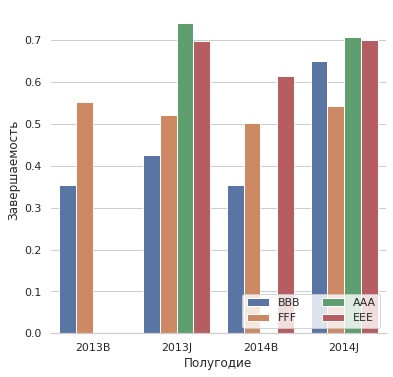

In [100]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=df_without_exem.sort_values(by='code_presentation'), x='code_presentation', 
            y='percent', hue='code_module')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Завершаемость",
       xlabel="Полугодие")
sns.despine(left=True)

## 6.Построить адаптированные RFM-кластеры студентов

Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

### Найдем среднее время сдачи экзамена на курсе (r_time)

In [135]:
df_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,pass_exam
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,1
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,1
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,1
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,1


In [136]:
df_r_time = df_exam.query("pass_exam == 1")\
    .groupby('id_student', as_index=False)\
    .agg({'date_submitted': 'mean'})\
    .rename(columns={'date_submitted': 'r_time'})

In [137]:
df_r_time.head()

,id_student,r_time
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0


In [138]:
df_r_time.shape

(4097, 2)

### Найдем F - завершаемость курсов (f_completion)

In [139]:
df_merge_st_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


Считаю сколько модулей пытался пройти студент. Если учащийся пытался пройти один и тотже модуль в разных семестрах (без отметки о пересдаче), то считаю все его попытки

In [140]:
df_f_attempt = df_merge_st_assessment\
    .query("(code_module == 'CCC' or code_module == 'DDD') and is_banked != 1")\
    .groupby(['id_student', 'code_presentation'], as_index=False)['code_module']\
    .nunique().groupby(['id_student'], as_index=False)\
    .agg({'code_module': 'sum'})\
    .rename(columns={'code_module': 'attempt'})

Успешные сдачи экзамена

In [141]:
df_f_completion = df_exam\
    .groupby(['id_student'], as_index=False)\
    .agg({'pass_exam': 'sum'})\
    .sort_values('pass_exam')

In [142]:
df_f_completion = pd.merge(df_f_attempt, df_f_completion, 
                           how='outer', on='id_student').fillna(0)

In [143]:
df_f_completion['f_completion'] = round(df_f_completion.pass_exam / df_f_completion.attempt * 100, 2)

In [144]:
# Удалили ненужные столбцы
df_f_completion.drop(['attempt', 'pass_exam'], axis=1, inplace=True)

### Найдем M - среднее количество баллов, получаемое за экзамен. (m_score)

In [145]:
df_exam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,pass_exam
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,1
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,1
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,1
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,1


In [146]:
df_m_score = df_exam.groupby('id_student', as_index=False)\
    .agg({'score': 'mean'}).rename(columns={'score': 'm_score'})\
    .fillna(0)

In [147]:
df_m_score.head()

,id_student,m_score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0


### Соединим данные в 1 датафрейм

In [148]:
df_rfm = pd.merge(df_m_score, df_f_completion, how='outer', on='id_student')
df_rfm = df_rfm.fillna(0)

In [149]:
df_rfm = pd.merge(df_rfm, df_r_time, how='outer', on='id_student')
df_rfm = df_rfm.fillna(math.inf)

In [150]:
df_rfm.head()

,id_student,m_score,f_completion,r_time
0,23698,80.0,100.0,243.0
1,24213,58.0,100.0,236.0
2,27116,96.0,100.0,243.0
3,28046,40.0,100.0,237.0
4,28787,44.0,100.0,243.0


In [151]:
# Проверим есть ли повторение id_student
if df_rfm.id_student.nunique() == df_rfm.shape[0]:
    print('OK')

OK


In [152]:
df_rfm.isna().sum()

id_student      0
m_score         0
f_completion    0
r_time          0
dtype: int64

In [153]:
df_rfm.agg({'m_score': ['describe']})

,m_score
,describe
count,7471.000000
mean,40.381676
std,35.480517
min,0.000000
25%,0.000000
50%,46.000000
75%,71.000000
max,100.000000


In [154]:
df_rfm.f_completion.unique()

array([100.  ,  50.  ,   0.  ,  66.67,  33.33])

In [155]:
df_rfm.groupby('f_completion').agg({'m_score': 'count'})

,m_score
f_completion,
0.00,3374
33.33,13
50.00,243
66.67,6
100.00,3835


Большая часть студентов (более 50%) имеют завершаемость курсов 100%. На мой взгляд, нет смысла выделять 5 когорт, а стоит разделить студентов, на три группы: что-то завалил, все сдал, завалил все экзамены.  
Обозначим границы категории completion (F - завершаемость курсов), разделив данные на 3 категорий:  
boundary_f_completion = {80:3, 10:2, 0:1}

Худшая оценка - 1, наилучшая - 3

Для определения границ метрик R - среднее время сдачи одного экзамена буду использовать квантили. Для оценки M - среднее количество баллов определю пороговые значения: больше 70 - отличники, от 69 до 40 хорошисты, меньше 40 - отстающие

In [156]:
def m_score(x, c='m_score'):
    if x >= 70:
        return 3
    elif x >= 40:
        return 2
    else:
        return 1

def r_score(x, c='r_time'):
    if x <= df_rfm[c].quantile(.33):
        return 3
    elif x <= df_rfm[c].quantile(.66):
        return 2
    else:
        return 1   

def f_completion(x, boundary_f_completion={80: 3, 10: 2, 0: 1}, c='f_completion'):
    key = list(boundary_f_completion.keys())
    for item in key:
        if x >= item:
            return boundary_f_completion[item]

In [157]:
df_rfm.head()

,id_student,m_score,f_completion,r_time
0,23698,80.0,100.0,243.0
1,24213,58.0,100.0,236.0
2,27116,96.0,100.0,243.0
3,28046,40.0,100.0,237.0
4,28787,44.0,100.0,243.0


In [158]:
df_rfm['r'] = df_rfm.r_time.apply(r_score)

In [159]:
df_rfm['f'] = df_rfm.f_completion.apply(f_completion)

In [160]:
df_rfm['m'] = df_rfm.m_score.apply(m_score)

In [161]:
df_rfm.shape[0]

7471

In [162]:
rfm_group = df_rfm.groupby(['r', 'm', 'f'], as_index=False)\
    .agg({'r_time': ['min', 'max'], 'm_score': ['min', 'max'],
          'f_completion': ['min', 'max'], 'id_student': 'count'})

In [163]:
column_names = list(map(lambda x: '_'.join(x), rfm_group.columns))
rfm_group.columns = column_names

In [164]:
rfm_group['rmf_score'] = rfm_group['r_'].map(str) \
    + rfm_group['m_'].map(str) + rfm_group['f_'].map(str) 

In [165]:
rfm_group

,r_,m_,f_,r_time_min,r_time_max,m_score_min,m_score_max,f_completion_min,f_completion_max,id_student_count,rmf_score
0,1,1,1,inf,inf,0.0,38.0,0.00,0.00,3374,111
1,1,1,2,243.0,243.0,33.5,33.5,50.00,50.00,1,112
2,1,2,2,243.0,250.0,40.0,69.0,50.00,50.00,48,122
3,1,2,3,242.5,285.0,40.0,69.5,100.00,100.00,634,123
4,1,3,2,243.0,250.0,71.0,100.0,50.00,66.67,17,132
5,1,3,3,242.5,259.0,70.0,100.0,100.00,100.00,715,133
6,3,1,2,234.0,237.0,32.0,38.5,33.33,50.00,6,312
7,3,2,2,229.0,242.0,40.0,69.0,33.33,66.67,135,322
8,3,2,3,229.0,242.0,40.0,69.5,100.00,100.00,1269,323
9,3,3,2,229.0,242.0,71.0,100.0,33.33,66.67,55,332


Оценки RFM дают нам 11 сегментов, с которыми можно спокойно работать, но я выделю 7 сегментов.  
Описание сегментов:  
время оценка завершаемость  
RMF  
333 - получают высокие оценки имеют высокую завершаемость курсов- торопыги отличники  
323 - быстро сдают работы, но более плохого качества (не все понимают) - торопыги хорошисты  
332 - не довели какой-то курс до конца, но получили отл на другом - пересдающие отличники 
322 - не довели какой-то курс до конца, но получили удв на другом - пересдающие хорошисты
[1-2]33 - получают хорошие оценки на экзаменах, проходят все курсы, но долго сдают экзамен - прокростинаторы отличники
[1-2]23 - получают удовлетворительные оценки на экзаменах, проходят все курсы, но долго сдают экзамен - прокрастинаторы хорошисты  
[1-3][1-2]2 - сдали хотя бы 1 экзамен, несмотря на плохие оценки - упорные  
111 - не сдали ни один курс до конца  

In [218]:
segt_map = {
    r'333': 'торопыги отличники',
    r'323': 'торопыги хорошисты',
    r'332': 'пересдающие отличники',
    r'322': 'пересдающие хорошисты',
    r'[1-2]3[2-3]': 'прокростинаторы отличники',
    r'[1-2]2[2-3]': 'прокрастинаторы хорошисты',
    r'[1-3][1-2]2': 'упорные',
    r'111': 'не сдали ни один курс до конца',
}

rfm_group['segment'] = rfm_group['r_'].map(str) + rfm_group['m_'].map(str)\
    + rfm_group['f_'].map(str)
rfm_group['segment'] = rfm_group['segment'].replace(segt_map, regex=True)

In [219]:
group_to_plot = rfm_group.groupby('segment', as_index=False)\
    .agg({'id_student_count': 'sum'})\
    .sort_values('id_student_count')
group_to_plot['percent'] = group_to_plot['id_student_count']\
    / group_to_plot['id_student_count'].sum()
group_to_plot

,segment,id_student_count,percent
7,упорные,7,0.000937
1,пересдающие отличники,55,0.007362
2,пересдающие хорошисты,135,0.018070
3,прокрастинаторы хорошисты,682,0.091286
4,прокростинаторы отличники,732,0.097979
5,торопыги отличники,1217,0.162897
6,торопыги хорошисты,1269,0.169857
0,не сдали ни один курс до конца,3374,0.451613


[Text(0, 0.5, ''), (0.0, 0.5), Text(0.5, 0, 'Число студентов')]

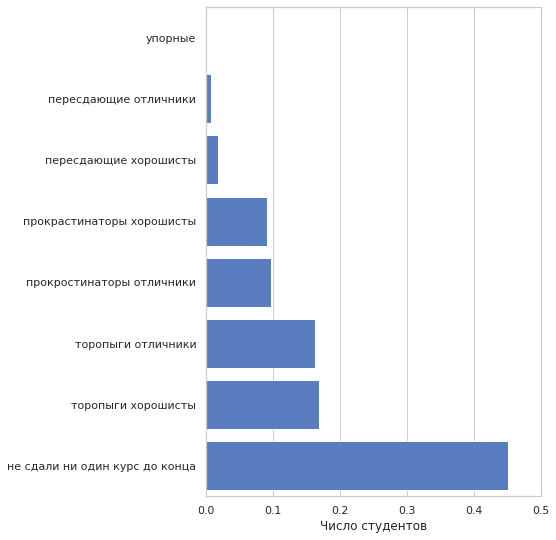

In [220]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 9))
sns.set_color_codes("muted")

sns.barplot(x="percent", y="segment", data=group_to_plot,
            color='b')

ax.set(xlim=(0, 0.5), ylabel="",
       xlabel="Число студентов")

Выводы:  
1. Большая часть студентов не заканчивает ни один курс (45%)
2. Из числа сдавших экзамен больше студентов, которые набрали от 40 до 69,9 баллов, чем от 70 до 100
3. Из числа студентов, которые сдают экзамен быстрее, большаая часть получают от 40 до 69,9 баллов 